<a href="https://colab.research.google.com/github/lkarjun/reverse-image-search/blob/main/rimg_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [3]:
!pip install fastai -Uqq

In [7]:
from fastai.vision.all import *

### Download dataset

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "lkarjun"

os.environ['KAGGLE_KEY'] = "96d0e367426087ce8a91876ea3de5244"

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification4
!unzip image-classification.zip

In [10]:
dataset_path = Path("/content/images/images")

## Here we go

### Dataloader

In [11]:
list_of_classes = ['architecure', 'art and culture']

fnames = get_image_files(dataset_path/list_of_classes[0])[:300] + get_image_files(dataset_path/list_of_classes[1])[:300]

In [64]:
item_tfms = Resize(224)
batch_tfms = Normalize.from_stats(*imagenet_stats)
bs=64

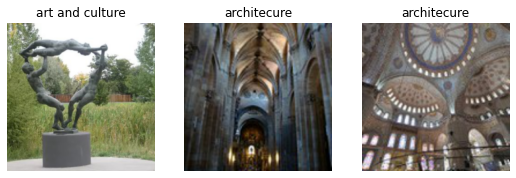

In [65]:
dls = ImageDataLoaders.from_path_func(dataset_path, fnames, 
                                lambda x: x.parent.name,
                                batch_tfms=batch_tfms, 
                                item_tfms=item_tfms, 
                                bs=bs)

dls.show_batch(max_n = 3)

In [66]:
x, y = dls.one_batch()
x.cuda()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### Model

In [67]:
body = create_body(resnet34, cut=-2)

In [193]:
head = create_head(nf = num_features_model(body), lin_ftrs=[512, 128], n_out = 2, concat_pool=False, pool=True)
head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [194]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [195]:
model = RImgModel(body, head).cuda()

In [196]:
def rimg_splitter(model):
    return L(model.body, model.head).map(params)

In [197]:
learn = Learner(dls, model, splitter=rimg_splitter, metrics=accuracy)

learn.freeze()

In [198]:
learn.summary()

RImgModel (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

In [199]:
learn.freeze()

In [200]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.486913,0.393673,0.791667,00:06
1,0.242918,0.048887,0.983333,00:06
2,0.155019,0.019649,0.991667,00:06
3,0.116024,0.018124,0.983333,00:06


In [201]:
# lower lr for body and high for head
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.005574,0.019138,0.991667,00:06
1,0.005204,0.019800,0.991667,00:06
2,0.005794,0.019809,0.991667,00:06
3,0.005860,0.019753,0.991667,00:07


### Geting feature vector

In [230]:
model.head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [264]:
with hook_output(learn.model.head[8]) as h:
    y = learn.predict(to_cpu(x[0]))
    print(h.stored.shape)

torch.Size([1, 128])


In [273]:
def get_feature_vector(dl):
  with hook_output(learn.model.head[8]) as h:
    y = learn.get_preds(dl=dl)
    print(h.stored.shape)

In [286]:
dl = learn.dls.test_dl(fnames)

In [275]:
get_feature_vector(dl)

torch.Size([36, 128])


In [285]:
for i in learn.get_preds():
  print(i[0].shape)

torch.Size([2])
torch.Size([])


In [295]:
for i in range(0, len(fnames), 100):
      print(fnames[i:i + 100])

[Path('/content/images/images/architecure/11466742974_d75f299de1_n.jpg'), Path('/content/images/images/architecure/4442084585_5e393b831f_m.jpg'), Path('/content/images/images/architecure/4510878016_eb2c72be4a_n.jpg'), Path('/content/images/images/architecure/1021881901_47c4bf6025_n.jpg'), Path('/content/images/images/architecure/120px-Avila_-_Catedral,_exteriores_16.jpg'), Path('/content/images/images/architecure/1248040345_43f7c2ac89_m.jpg'), Path('/content/images/images/architecure/7947288126_d88138304a_n.jpg'), Path('/content/images/images/architecure/3360948172_f036262cbd_m.jpg'), Path('/content/images/images/architecure/2982333036_57f7c665a5_n.jpg'), Path('/content/images/images/architecure/8982566829_31a56dbca7_n.jpg'), Path('/content/images/images/architecure/3499120038_d5751eea76.jpg'), Path('/content/images/images/architecure/8465223980_8818e6e183_n.jpg'), Path('/content/images/images/architecure/5931979616_afbbd44372_m.jpg'), Path('/content/images/images/architecure/295068682